#### Importing Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import optuna
import matplotlib.pyplot as plt

#### Load and Preprocess Data

In [ ]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load data
file_path = 'GOOG.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Filtering data till 2020 -> pre pandemic
data = data[data['Date'].dt.year <= 2020]

# Extracting target and train, test val dataset
values = data['Close'].values.astype('float32').reshape(-1, 1)
train_size = int(len(values) * 0.7)
val_size = int(len(values) * 0.15)
test_size = len(values) - train_size - val_size

train_data, val_data, test_data = np.split(values, [train_size, train_size + val_size])

# Scaling Data, fitting on Train Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data).flatten()
val_data_scaled = scaler.transform(val_data).flatten()
test_data_scaled = scaler.transform(test_data).flatten()

#### Dataset class

In [ ]:
# Defining  and calling the dataset for time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 30
train_dataset = TimeSeriesDataset(train_data_scaled, sequence_length)
val_dataset = TimeSeriesDataset(val_data_scaled, sequence_length)
test_dataset = TimeSeriesDataset(test_data_scaled, sequence_length)

#### Defining Model

In [ ]:
#  RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    train_loss_list, val_loss_list = [], []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.unsqueeze(-1).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.unsqueeze(-1).to(device)
                y_val = y_val.to(device)
                val_output = model(x_val)
                val_loss = criterion(val_output.squeeze(), y_val)
                running_val_loss += val_loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_loss_list.append(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_loss_list, val_loss_list

def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.unsqueeze(-1).to(device)
            y_test = y_test.to(device)
            output = model(x_test)
            predictions.extend(output.squeeze().cpu().tolist())
            targets.extend(y_test.cpu().tolist())

    # Inverse transform predictions and targets to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    return mse, mae, rmse, r2, predictions, targets

Using device: cuda


#### Hyper-parameter Optimization

In [ ]:
# Optuna Optimization
def objective(trial):
    # Parameter Search Space
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])


    model = VanillaRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=15)
    return min(val_loss)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
print("Best parameters:", best_params)


[I 2024-12-07 14:09:32,683] A new study created in memory with name: no-name-a1ba111c-67a6-48a8-8ab5-2a946d868e72
[I 2024-12-07 14:09:51,407] Trial 0 finished with value: 0.0005477542040721715 and parameters: {'hidden_size': 76, 'num_layers': 2, 'learning_rate': 0.0024457092679872625, 'batch_size': 16}. Best is trial 0 with value: 0.0005477542040721715.


Early stopping at epoch 34


[I 2024-12-07 14:10:15,143] Trial 1 finished with value: 0.00029626556734958857 and parameters: {'hidden_size': 122, 'num_layers': 1, 'learning_rate': 0.0016516869074344504, 'batch_size': 32}. Best is trial 1 with value: 0.00029626556734958857.
[I 2024-12-07 14:10:21,548] Trial 2 finished with value: 0.0007191095690359361 and parameters: {'hidden_size': 125, 'num_layers': 3, 'learning_rate': 0.0016926844686078403, 'batch_size': 64}. Best is trial 1 with value: 0.00029626556734958857.
[I 2024-12-07 14:10:31,771] Trial 3 finished with value: 0.07721212805395103 and parameters: {'hidden_size': 114, 'num_layers': 3, 'learning_rate': 0.00542931776363744, 'batch_size': 16}. Best is trial 1 with value: 0.00029626556734958857.


Early stopping at epoch 27


[I 2024-12-07 14:10:37,539] Trial 4 finished with value: 0.004842180391087344 and parameters: {'hidden_size': 121, 'num_layers': 2, 'learning_rate': 0.007397382954271891, 'batch_size': 32}. Best is trial 1 with value: 0.00029626556734958857.


Early stopping at epoch 26


[I 2024-12-07 14:10:47,644] Trial 5 finished with value: 0.01321007147198543 and parameters: {'hidden_size': 56, 'num_layers': 1, 'learning_rate': 0.00012785393526143577, 'batch_size': 64}. Best is trial 1 with value: 0.00029626556734958857.
[I 2024-12-07 14:10:54,790] Trial 6 finished with value: 0.01480799408745952 and parameters: {'hidden_size': 34, 'num_layers': 3, 'learning_rate': 0.00013894583894481178, 'batch_size': 64}. Best is trial 1 with value: 0.00029626556734958857.
[I 2024-12-07 14:11:31,628] Trial 7 finished with value: 0.000291247420210385 and parameters: {'hidden_size': 123, 'num_layers': 1, 'learning_rate': 0.0016644042432074223, 'batch_size': 16}. Best is trial 7 with value: 0.000291247420210385.


Early stopping at epoch 45


[I 2024-12-07 14:12:15,445] Trial 8 finished with value: 0.00036551440250666537 and parameters: {'hidden_size': 57, 'num_layers': 1, 'learning_rate': 0.0005285540377722319, 'batch_size': 16}. Best is trial 7 with value: 0.000291247420210385.
[I 2024-12-07 14:12:35,284] Trial 9 finished with value: 0.004873658779711389 and parameters: {'hidden_size': 21, 'num_layers': 3, 'learning_rate': 0.0004826260408430964, 'batch_size': 32}. Best is trial 7 with value: 0.000291247420210385.
[I 2024-12-07 14:13:21,286] Trial 10 finished with value: 0.00032317718894872186 and parameters: {'hidden_size': 95, 'num_layers': 1, 'learning_rate': 0.0004934048602137778, 'batch_size': 16}. Best is trial 7 with value: 0.000291247420210385.
[I 2024-12-07 14:13:44,530] Trial 11 finished with value: 0.0003156869934173301 and parameters: {'hidden_size': 95, 'num_layers': 1, 'learning_rate': 0.002283120589727402, 'batch_size': 32}. Best is trial 7 with value: 0.000291247420210385.
[I 2024-12-07 14:13:55,930] Trial 

Early stopping at epoch 48


[I 2024-12-07 14:14:14,382] Trial 13 finished with value: 0.0002857732389728833 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.004247898169474772, 'batch_size': 32}. Best is trial 13 with value: 0.0002857732389728833.


Early stopping at epoch 45


[I 2024-12-07 14:14:44,272] Trial 14 finished with value: 0.0003241856220238087 and parameters: {'hidden_size': 76, 'num_layers': 1, 'learning_rate': 0.0038326984772135597, 'batch_size': 16}. Best is trial 13 with value: 0.0002857732389728833.


Early stopping at epoch 35


[I 2024-12-07 14:14:55,119] Trial 15 finished with value: 0.3436753345099655 and parameters: {'hidden_size': 106, 'num_layers': 2, 'learning_rate': 0.009904451155099359, 'batch_size': 16}. Best is trial 13 with value: 0.0002857732389728833.


Early stopping at epoch 17


[I 2024-12-07 14:15:15,427] Trial 16 finished with value: 0.0003143109195087546 and parameters: {'hidden_size': 85, 'num_layers': 1, 'learning_rate': 0.0037586233222161873, 'batch_size': 32}. Best is trial 13 with value: 0.0002857732389728833.
[I 2024-12-07 14:15:25,784] Trial 17 finished with value: 0.0003785410555888359 and parameters: {'hidden_size': 107, 'num_layers': 2, 'learning_rate': 0.0010326718464026747, 'batch_size': 32}. Best is trial 13 with value: 0.0002857732389728833.


Early stopping at epoch 47


[I 2024-12-07 14:16:03,923] Trial 18 finished with value: 0.000275537673587678 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.004283269401768351, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.


Early stopping at epoch 47


[I 2024-12-07 14:16:17,670] Trial 19 finished with value: 0.0005074017382867169 and parameters: {'hidden_size': 57, 'num_layers': 1, 'learning_rate': 0.004845254938023222, 'batch_size': 64}. Best is trial 18 with value: 0.000275537673587678.
[I 2024-12-07 14:16:27,369] Trial 20 finished with value: 0.0004940512562579652 and parameters: {'hidden_size': 113, 'num_layers': 2, 'learning_rate': 0.003062038169274079, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.


Early stopping at epoch 24


[I 2024-12-07 14:17:00,650] Trial 21 finished with value: 0.004866258228257475 and parameters: {'hidden_size': 125, 'num_layers': 1, 'learning_rate': 0.006397756063473921, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.


Early stopping at epoch 39


[I 2024-12-07 14:17:43,201] Trial 22 finished with value: 0.0002792643274399263 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.0015482111950386051, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.
[I 2024-12-07 14:18:29,603] Trial 23 finished with value: 0.0002827245236305218 and parameters: {'hidden_size': 115, 'num_layers': 1, 'learning_rate': 0.0007579370488946282, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.


Early stopping at epoch 49


[I 2024-12-07 14:19:13,186] Trial 24 finished with value: 0.0002766760070871159 and parameters: {'hidden_size': 113, 'num_layers': 1, 'learning_rate': 0.000749436616496731, 'batch_size': 16}. Best is trial 18 with value: 0.000275537673587678.


Best parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.004283269401768351, 'batch_size': 16}


#### Training the model with Best-Parameters

Early stopping at epoch 50
MSE: 13.8485, MAE: 3.1385, RMSE: 3.7214, R²: 0.8680


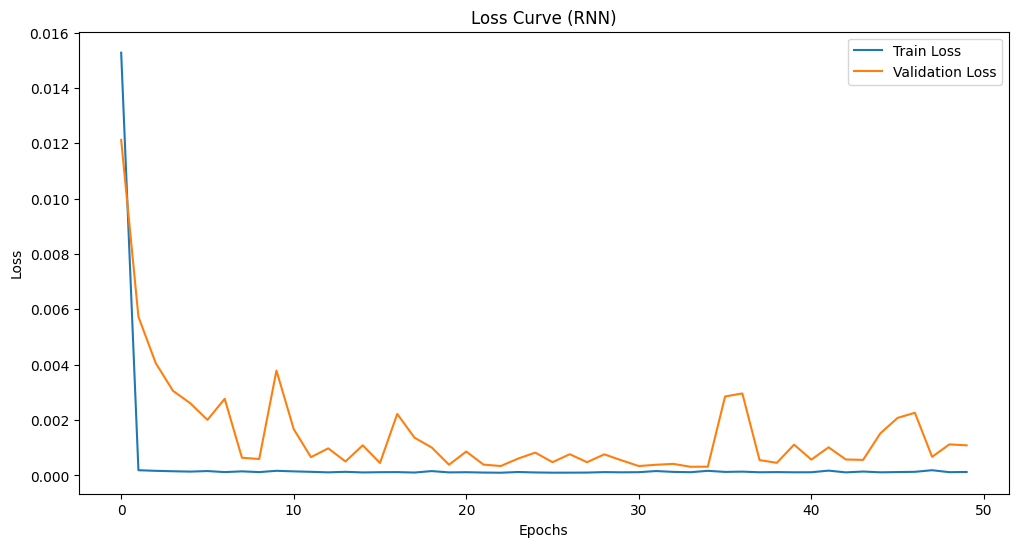

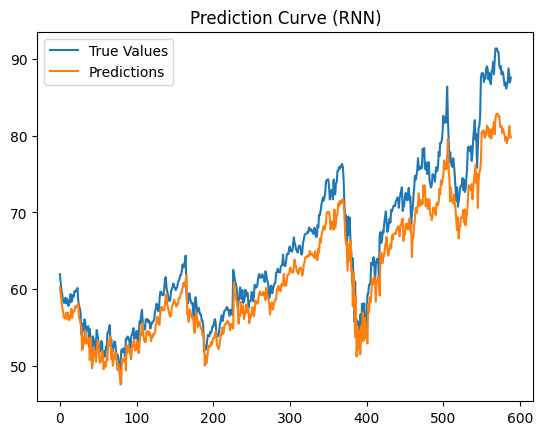

In [ ]:

# Final Training with Best Parameters
model_type="RNN"
final_model = VanillaRNN(input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_layers"]).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])

final_batch_size = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=final_batch_size)
test_loader = DataLoader(test_dataset, batch_size=final_batch_size)

train_loss, val_loss = train_model(final_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15)

mse, mae, rmse, r2, predictions, targets = evaluate_model(final_model, test_loader)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title(f"Loss Curve ({model_type})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot predictions vs targets
plt.figure()
plt.plot(targets, label='True Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title(f"Prediction Curve ({model_type})")
plt.show()
